# Mixture Density Networks

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Simple Case: 1D Regression

### Generate Data

<center>$y_{true}(x) = 7sin(0.75)+0.5x+\epsilon$</center>

- $\epsilon$ adds random noise

In [7]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7 * np.sin(0.75 * x_data) + 0.5 * x_data + epsilon
    return x_data, y_data

In [8]:
n_samples = 1000
x_data, y_data = generate_data(n_samples)

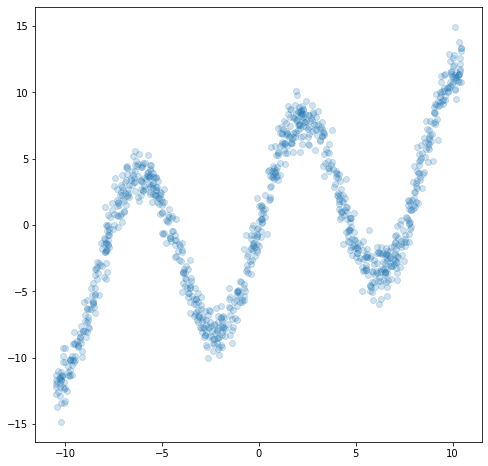

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()

__Plot x vs y__

In this case is very difficult to build a simple linear model, since there many y values for different x values, i.e. we ebcounter data multimodality

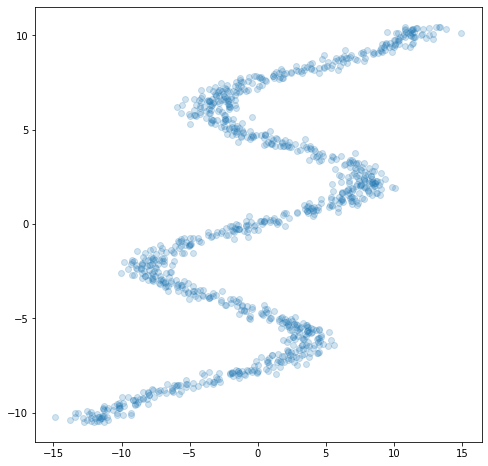

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.show()

__Move from Numpy to Torch__

Change data type and shape:
- Convert to np.float32 (torch default) from np.float64 (numpy default)
- change shape

In [224]:
x_tensor = torch.from_numpy(np.float32(x_data)).reshape(n_samples, 1)
y_tensor = torch.from_numpy(np.float32(y_data)).reshape(n_samples, 1)

flip the data for the multimodal case

In [204]:
x_variable = Variable(y_tensor)
y_variable = Variable(x_tensor, requires_grad=False)

In [225]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

### Build MDN Model

In [226]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super().__init__()
        self.fc1 = nn.Linear(1, n_hidden)
        self.pi = nn.Linear(n_hidden, n_gaussians)
        self.mu = nn.Linear(n_hidden, n_gaussians)
        self.sigma = nn.Linear(n_hidden, n_gaussians)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        
        pi_logits = self.pi(x)
        sigma_logits = self.sigma(x)
        mu = self.mu(x)       
        
        #normalize pi, so that sum(pi)=1
        pi = F.softmax(pi_logits, dim=1)
        #ensure sigma is positive
        sigma = torch.exp(sigma_logits)
        
        return pi, mu, sigma

### Write the Loss Function

In [238]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0 * np.pi) # normalization factor for Gaussians

def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, mu, sigma, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

### Create the Model

In [239]:
MDN_net = MDN(n_hidden=20, n_gaussians=5).to(device)
print(MDN_net)

MDN(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (pi): Linear(in_features=20, out_features=5, bias=True)
  (mu): Linear(in_features=20, out_features=5, bias=True)
  (sigma): Linear(in_features=20, out_features=5, bias=True)
)


In [240]:
optimizer = optim.Adam(MDN_net.parameters())

### Train MDN 

In [241]:
MDN_net.to(device)
x_variable = x_variable.cuda()
y_variable = y_variable.cuda()

In [242]:
x_variable.is_cuda

True

In [260]:
def train_MDN():
    for epoch in range(20000):
        x_variable.to(device)
        y_variable.to(device)
        pi_values, mu_values, sigma_values = MDN_net(x_variable)
        loss = mdn_loss_fn(pi_values, mu_values, sigma_values, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 2000 == 0:
            print(epoch, loss.item())

In [261]:
train_MDN()

0 1.2968381643295288
2000 1.2949583530426025
4000 1.2940747737884521
6000 1.2922158241271973
8000 1.2900439500808716
10000 1.2888928651809692
12000 1.2984201908111572
14000 1.286968469619751
16000 1.2871094942092896
18000 1.2862122058868408


### Test

In [262]:
x_test_data = np.linspace(-15, 15, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, 1))
x_test_variable = Variable(x_test_tensor)

x_test_variable = x_test_variable.cuda()

In [263]:
pi_hat_variable, mu_hat_variable, sigma_hat_variable = MDN_net(x_test_variable)

# move to cpu
pi_hat_variable = pi_hat_variable.cpu()
sigma_hat_variable = sigma_hat_variable.cpu()
mu_hat_variable = mu_hat_variable.cpu()

pi_data = pi_hat_variable.data.numpy()
sigma_data = sigma_hat_variable.data.numpy()
mu_data = mu_hat_variable.data.numpy()


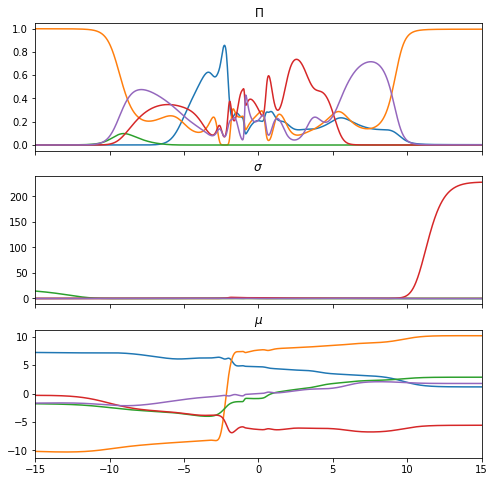

In [264]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

In [273]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

In [274]:
k.shape

(1000,)

 We use np.random.randn to sample from a Gaussian in each sample, scaling it by $\sigma$ and offsetting it by $\mu$.

In [275]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

Plot?

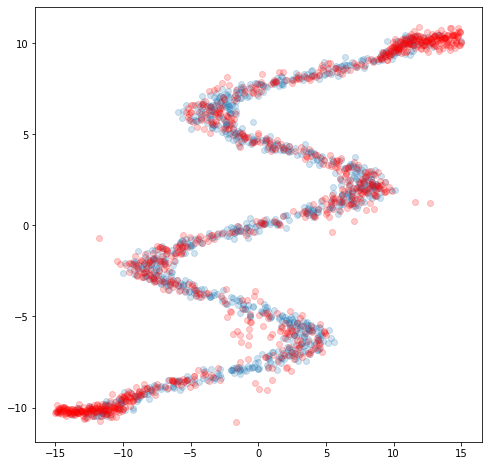

In [276]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

### Indexing Aux Operation

In [127]:
sigma_data.shape

(1000, 5)

In [128]:
indices

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [133]:
type(indices[0])

numpy.ndarray

In [135]:
sigma_data.shape

(1000, 5)

In [192]:
a = sigma_data[indices[0][0], indices[1][450]]

In [193]:
a

0.9911548

In [171]:
indices[0][1]

1

In [172]:
indices[1][1]

0

In [180]:
sigma_data[0][0:2]

array([-10.194052 ,  -2.3468134], dtype=float32)

In [183]:
sigma_data[1][0:5]

array([-10.195463  ,  -2.3466122 ,  -5.422621  ,   0.99948704,
        -1.4924402 ], dtype=float32)

In [184]:
sigma_data[1]

array([-10.195463  ,  -2.3466122 ,  -5.422621  ,   0.99948704,
        -1.4924402 ], dtype=float32)

In [185]:
sigma_data.shape

(1000, 5)